In [17]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import print_function
import torch
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
from IPython.display import clear_output
import time
import csv

images = np.load('images.npy')
labels = np.load('labels.npy')
images1 = np.load('part_2_test_images.npy')


num_images,height,width = np.shape(images)
images = images.astype(float)
HEIGHT = images.shape[1]
WIDTH = images.shape[2]
images = np.reshape(images,(num_images,height*width))



num_images1,height1,width1 = np.shape(images1)
images1 = images1.astype(float)
images1 = np.reshape(images1,(num_images1,height1*width1))




labels = labels.astype(int)



x_valid = images[45000:50000][:]

y_valid = labels[45000:50000]


x_train = images[0:45000][:]

y_train = labels[0:45000]



val_predict = images1

train_seqs = x_train
train_labels = y_train

val_seqs = x_valid
val_labels = y_valid


#constants
max_count = np.bincount(train_labels)
NUM_CLASSES = np.size(max_count)
NUM_EXAMPLES = np.shape(train_seqs)[0]
NUM_OPT_STEPS = 2000
batch_size = 128;

In [24]:
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3,stride = 2)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 48, kernel_size=3, stride=2)
        self.conv3 = torch.nn.Conv2d(48, 80, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(80, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        m = torch.nn.Dropout2d(p=0.2)
        x = F.relu(self.conv2(m(x)))
        x = F.relu(self.conv3(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
    def eval(self,x):
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
        

model = TooSimpleConvNN()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(batch_size):
    #model.train() puts our model in train mode, which can require different behaviour than eval mode (for example
    #in the case of dropout
    #model.train()
    #i is a 1 dimensional array with shape[batch_size]
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.float32)))
    y_hat_ = model(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)
    

def approx_val_accuracy():
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    x = autograd.Variable(torch.from_numpy(val_seqs.astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(val_labels.astype(np.float32)))
    y_hat_ = model.eval(x)
    temp,y_hat = torch.max(y_hat_,1)
    return accuracy(y,y_hat)


def val_prediction():
    x = autograd.Variable(torch.from_numpy(val_predict.astype(np.float32)))
    y_hat_ = model.eval(x)
    temp,y_hat = torch.max(y_hat_,1)
    return y_hat
    

def accuracy(y,y_hat):
    correct = np.count_nonzero(y_hat.data.numpy()==y.data.numpy())
    return correct/y.data.shape[0]

for m in model.children():
    m.reset_parameters()

#time
t = time.time()
#training
train_accs, val_accs, answer =[], [], []
for i in range(NUM_OPT_STEPS):
    loss = train(batch_size)
    if i%100==0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(approx_val_accuracy())
        print("%6d %5.2f %5.2f"%(i,train_accs[-1]*100,val_accs[-1]*100))

elapsed = time.time() - t
print('Total training time approx. =',elapsed,'secs')

     0 21.60 19.30
   100 78.00 82.14
   200 82.60 85.40
   300 85.90 86.38
   400 87.00 87.90
   500 89.60 88.82
   600 86.70 88.82
   700 88.70 89.62
   800 90.40 89.98
   900 91.50 90.14
  1000 91.70 90.56
  1100 91.50 90.20
  1200 91.80 90.82
  1300 91.30 90.72
  1400 90.60 90.44
  1500 92.70 90.60
  1600 92.50 90.38
  1700 93.10 91.02
  1800 92.20 90.32
  1900 94.20 91.12
Total training time approx. = 127.91087675094604 secs


Text(0.5,1,'Training accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'optimization steps')

average accuracy =  0.8618


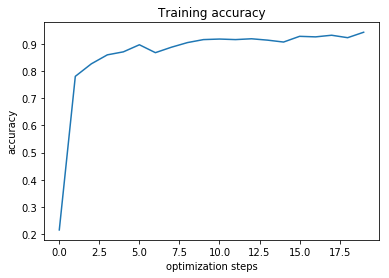

In [211]:
plt.plot(train_accs)
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(train_accs))

Text(0.5,1,'Validation accuracy')

Text(0,0.5,'accuracy')

Text(0.5,0,'optimization steps')

average accuracy =  0.85734


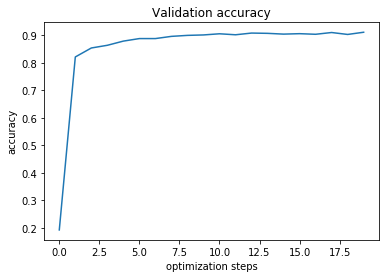

In [212]:
plt.plot(val_accs)
plt.title('Validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('optimization steps')
print('average accuracy = ',np.mean(val_accs))

In [213]:
print('Max training accuracy=',np.max(train_accs), 'for',NUM_OPT_STEPS ,'optimization steps')
print('Max validation accuracy=',np.max(val_accs), 'for',NUM_OPT_STEPS, 'optimization steps')
print('batch_size=',batch_size)
print('Learning rate=',1e-3)
print('optimizer = Adam')
print('Total training time approx. =',elapsed,'secs')

Max training accuracy= 0.942 for 2000 optimization steps
Max validation accuracy= 0.9112 for 2000 optimization steps
batch_size= 128
Learning rate= 0.001
optimizer = Adam
Total training time approx. = 127.91087675094604 secs


In [218]:
answer.append(val_prediction())

from IPython.display import clear_output
import csv

csv_nos = []

ans = answer[0].data.numpy()


for i in range(0,ans.shape[0]):
    csv_nos.append([i,ans[i]])
    

f = open('weights.csv', 'w')

with f:
    
    fnames = ['id', 'label']
    writer = csv.DictWriter(f, fieldnames=fnames)    

    writer.writeheader()
    for i in range(0,ans.shape[0]):
        writer.writerow({'id' : i, 'label': ans[i]})
        clear_output()
    

        

8

Adam optimizer with learning rate of 1e-3
-  Started with the configurations in 13 i.e 1 stride in both and 2 convolutional layers 16 filters in each layer, Batch size of 128. Training time was slow
-  Changed to 2 strides in both layers with 16 filters in each layer, batch size of 128
-  Added an extra layer to the above configuration with 16 filters. i.e 3 layer convolutional neural net and reduced batch size to 2000 to improve time performance
-  Added more filters to the above configuration i.e 32 filters to the last layer
-  Added more filters in each layer i.e made each layer have 32 filters
-  Made batch size to 3000 and changed stride of 3rd hidden layer as 4
-  Revert back to stride 2 for last layer and add dropout of p=0.2 to first layer
-  Added dropout with p=0.2 before 2nd layer
-  Added dropout with p=0.2 before 3rd layer

In [53]:
# failure modes
# make predictions from validation set(not kaggle)
def val_prediction_mode():
    x = autograd.Variable(torch.from_numpy(val_seqs.astype(np.float32)))
    y_hat_ = model.eval(x)
    temp,y_hat = torch.max(y_hat_,1)
    return y_hat

mode = val_prediction_mode()



In [150]:
correct_class_index = np.array(np.where(mode.data.numpy() == val_labels))
wrong_class_index = np.array(np.where(mode.data.numpy() != val_labels))

In [151]:
wrong = val_seqs[wrong_class_index[0][0:10]]
correct = val_seqs[correct_class_index[0][0:10]]
plt.set_cmap('gray')

In [184]:
figures = {0:'apple',1:'baseball',2:'clock',3:'cookie',4:'fan'}

Plotting wrongly classified images

Integer associated with:
apple = 0;
baseball = 1;
Clock = 3;
Cookie = 2;
Fan =4;

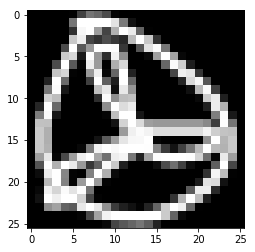

This image is classified as  baseball
But it is actually fan


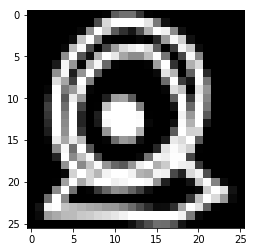

This image is classified as  clock
But it is actually fan


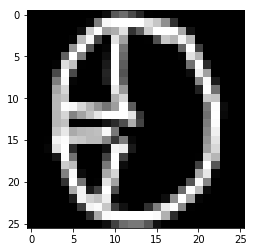

This image is classified as  cookie
But it is actually baseball


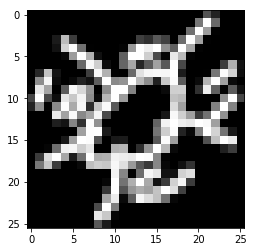

This image is classified as  baseball
But it is actually fan


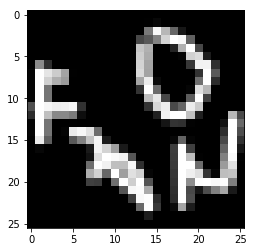

This image is classified as  baseball
But it is actually fan


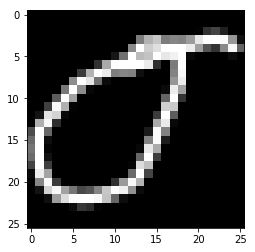

This image is classified as  baseball
But it is actually apple


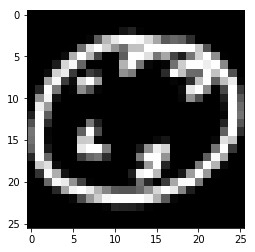

This image is classified as  clock
But it is actually cookie


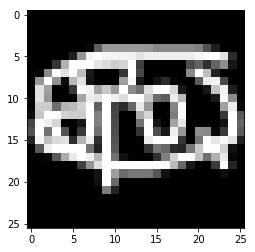

This image is classified as  baseball
But it is actually fan


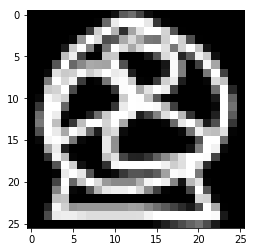

This image is classified as  baseball
But it is actually fan


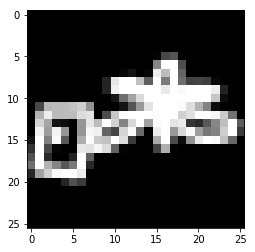

This image is classified as  baseball
But it is actually fan


In [189]:
for i in range(0,10):
    plt.figure()
    plt.imshow(np.resize(wrong[0][i],(HEIGHT,WIDTH)))
    plt.show()
    print('This image is classified as ',figures[mode[wrong_class_index[0][i]].data.numpy()[0]])
    print('But it is actually',figures[val_labels[wrong_class_index[0][i]]])
    

Actually there arent any qualitative differences between the images. Most of the misclassified images are hard to classify even for us humans.

Plotting correctly classified images

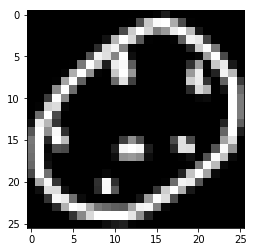

This image is classified as  clock


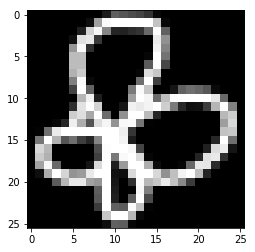

This image is classified as  fan


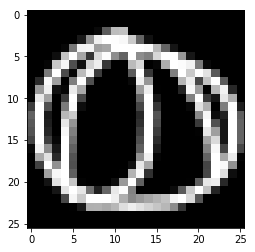

This image is classified as  baseball


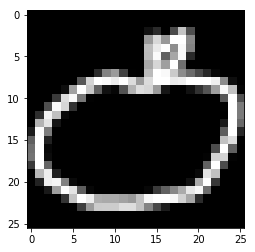

This image is classified as  apple


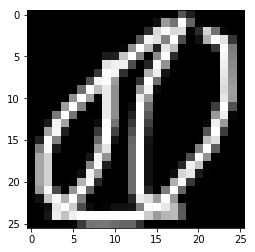

This image is classified as  baseball


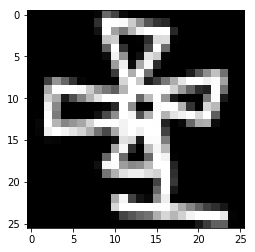

This image is classified as  fan


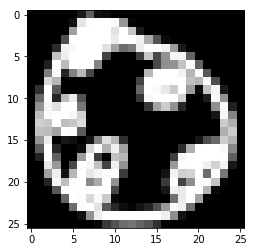

This image is classified as  clock


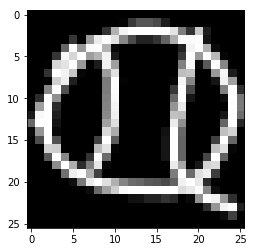

This image is classified as  baseball


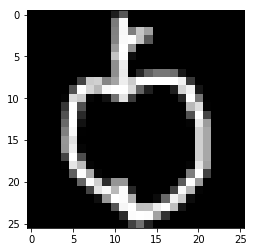

This image is classified as  apple


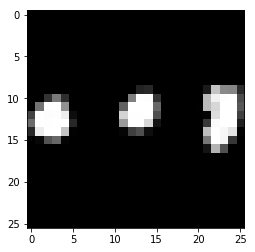

This image is classified as  clock


In [190]:
for i in range(0,10):
    plt.figure()
    plt.imshow(np.resize(correct[0][i],(HEIGHT,WIDTH)))
    plt.show()
    print('This image is classified as ',figures[mode[correct_class_index[0][i]].data.numpy()[0]])


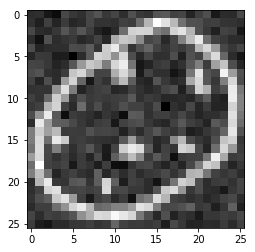

This is predicted as clock
but it is acutally clock


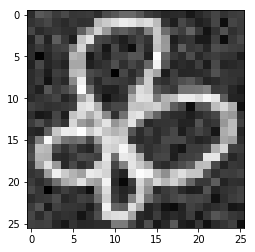

This is predicted as fan
but it is acutally fan


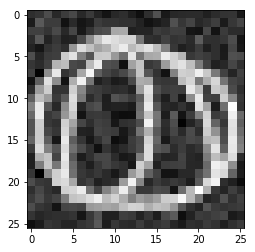

This is predicted as baseball
but it is acutally baseball


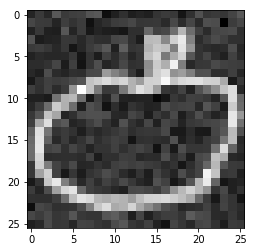

This is predicted as apple
but it is acutally apple


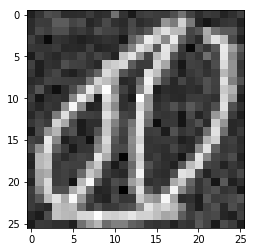

This is predicted as baseball
but it is acutally baseball


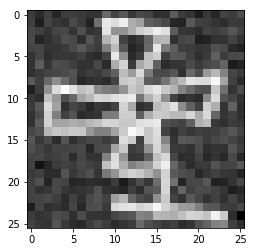

This is predicted as fan
but it is acutally fan


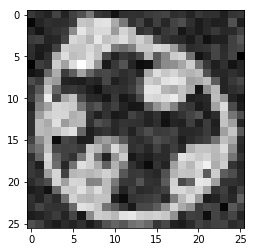

This is predicted as clock
but it is acutally clock


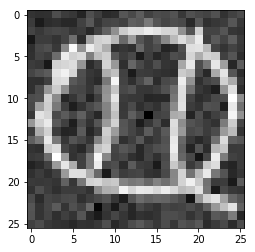

This is predicted as baseball
but it is acutally baseball


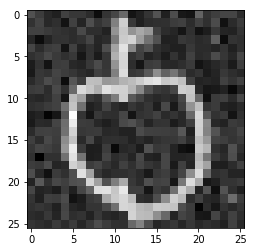

This is predicted as apple
but it is acutally apple


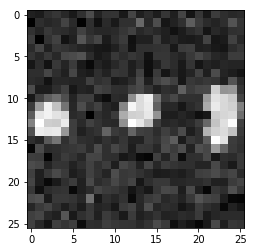

This is predicted as clock
but it is acutally clock


In [208]:
def val_prediction_mode_index(imag):
    x = autograd.Variable(torch.from_numpy(imag.astype(np.float32)))
    y_hat_ = model.eval(x)
    temp,y_hat = torch.max(y_hat_,1)
    return y_hat


for i in range(0,10):
    temp = np.resize(correct[0][i],(HEIGHT,WIDTH))
    max = np.max(temp)
    min = np.min(temp)
    mean = 0
    std_dev = (max-min)/10
    noise = np.random.normal(mean,std_dev,(26,26))
    temp = temp+noise
    plt.imshow(temp)
    plt.show()
    #perform prediction
    predict = val_prediction_mode_index(temp)
    print('This is predicted as',figures[predict.data.numpy()[0]])
    print('but it is acutally',figures[mode[correct_class_index[0][i]].data.numpy()[0]])
    


It actually predicts the label correctly even after adding gaussian noise

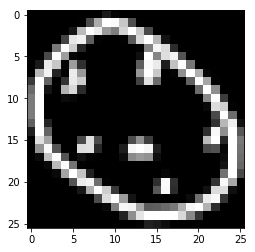

This is predicted as clock
but it is acutally clock


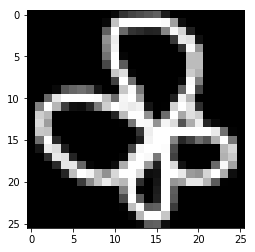

This is predicted as baseball
but it is acutally fan


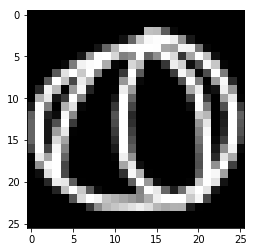

This is predicted as baseball
but it is acutally baseball


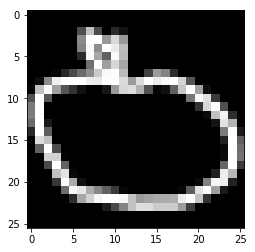

This is predicted as apple
but it is acutally apple


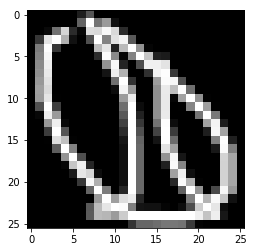

This is predicted as baseball
but it is acutally baseball


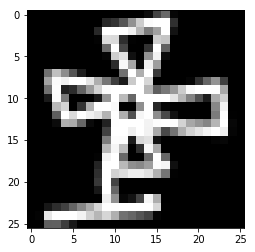

This is predicted as fan
but it is acutally fan


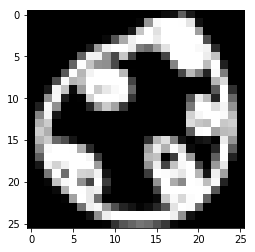

This is predicted as clock
but it is acutally clock


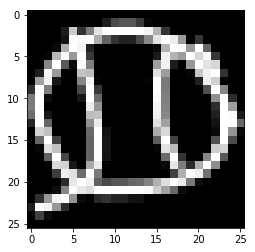

This is predicted as baseball
but it is acutally baseball


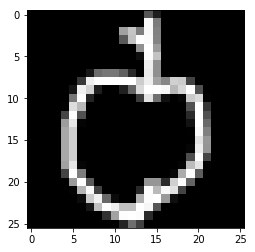

This is predicted as apple
but it is acutally apple


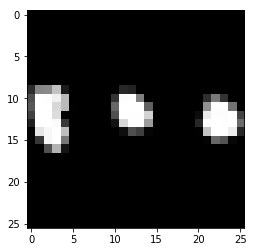

This is predicted as clock
but it is acutally clock


In [210]:
def val_prediction_mode_index(imag):
    x = autograd.Variable(torch.from_numpy(imag.astype(np.float32)))
    y_hat_ = model.eval(x)
    temp,y_hat = torch.max(y_hat_,1)
    return y_hat


for i in range(0,10):
    temp = np.resize(correct[0][i],(HEIGHT,WIDTH))
    temp = np.flip(temp,1)
    plt.imshow(temp)
    plt.show()
    #perform prediction
    predict = val_prediction_mode_index(temp)
    print('This is predicted as',figures[predict.data.numpy()[0]])
    print('but it is acutally',figures[mode[correct_class_index[0][i]].data.numpy()[0]])
    



As you can see, there is a misprediction in the second image, where the image is a fan but our network predicted it as a baseball. So accuracy = 9/10

-  No it need not be a failure, since sometimes, the flipped images could mean something else(eg. during pose detection of objects)
-  If we want to make the network invariant to flipping, we can generate data on the go during training. i.e during training, we can flip a small no of images in random before passing it through our cnn


__KAGGLE USERNAME__ = __Lash__ 